In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import swe2hs as jopack

In [190]:
df= pd.read_csv('automatic_stations_validation_data.csv')
df.head()
df['site_id'].value_counts()
df=df[df['site_id']=='WFJ_aws']
df

,date,HS_[m],SWE_[m],site_id,HS_interpolated,SWE_interpolated
19505,2018-10-26,0.00,0.000000,WFJ_aws,False,False
19506,2018-10-27,0.04,0.008300,WFJ_aws,False,False
19507,2018-10-28,0.52,0.064050,WFJ_aws,False,False
19508,2018-10-29,0.45,0.078110,WFJ_aws,False,False
19509,2018-10-30,0.60,0.117800,WFJ_aws,False,False
...,...,...,...,...,...,...
23087,2016-07-18,0.00,0.004642,WFJ_aws,False,False
23088,2016-07-19,0.00,0.000000,WFJ_aws,False,False
23089,2016-08-04,0.00,0.000000,WFJ_aws,False,False
23090,2016-08-05,0.00,0.001305,WFJ_aws,False,False


In [103]:
df.isna().sum()

date                0
HS_[m]              1
SWE_[m]             0
site_id             0
HS_interpolated     0
SWE_interpolated    0
dtype: int64

In [110]:
# Convert 'HS_[m]' to float first
df['HS_[m]'] = df['HS_[m]'].astype(float)
# Fill the missing value with mean
df['HS_[m]'].fillna(df['HS_[m]'].mean(), inplace=True)
# Check again
df.isna().sum()


C:\Users\AS\AppData\Local\Temp\ipykernel_24616\624249134.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['HS_[m]'].fillna(df['HS_[m]'].mean(), inplace=True)


date                0
HS_[m]              0
SWE_[m]             0
site_id             0
HS_interpolated     0
SWE_interpolated    0
dtype: int64

In [ ]:
# 1. Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])
# 2. Set date as index
df_ts = df.set_index('date')
# 3. Keep only SWE column (rename to 'swe' if you want)
df_ts = df_ts[['SWE_[m]','HS_[m]']].rename(columns={'SWE_[m]': 'swe','HS_[m]':'actual_hs'})


In [112]:
swe=df_ts
swe

,swe,actual_hs
date,,
2018-10-26,0.000000,0.00
2018-10-27,0.008300,0.04
2018-10-28,0.064050,0.52
2018-10-29,0.078110,0.45
2018-10-30,0.117800,0.60
...,...,...
2016-07-18,0.004642,0.00
2016-07-19,0.000000,0.00
2016-08-04,0.000000,0.00


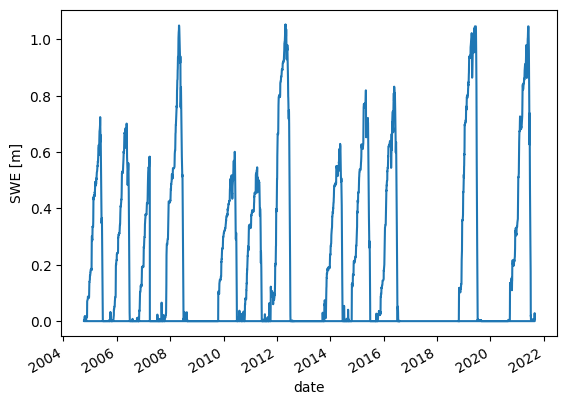

In [113]:
# swe = create_swe(n_years=3)
swe['swe'].plot(ylabel='SWE [m]')
plt.show()


In [123]:
predicted_hs = jopack.convert_1d(swe['swe'], swe_input_unit='m', hs_output_unit='m')
# predicted_hs

In [124]:
print(swe['actual_hs'].count())
print(predicted_hs.count())


3587
3587


In [125]:
# hs validation/score model

from sklearn.metrics import r2_score
r2_score(swe['actual_hs'], predicted_hs)

0.9340244723540715

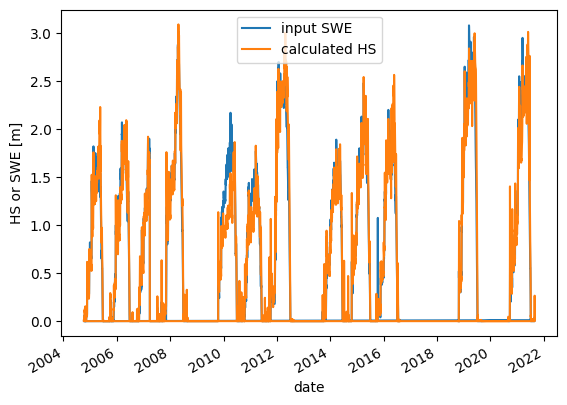

In [126]:
fig, ax = plt.subplots()
swe['actual_hs'].plot(label='input SWE')
predicted_hs.plot(label='calculated HS')
ax.legend()
ax.set_ylabel('HS or SWE [m]')
plt.show()


In [127]:
hs_with_layers = jopack.convert_1d(swe['swe'], return_layers=True)
hs_with_layers


<xarray.Dataset> Size: 31MB
Dimensions:              (time: 3587, layers: 364)
Coordinates:
  * time                 (time) datetime64[ns] 29kB 2018-10-26 ... 2016-08-06
  * layers               (layers) int64 3kB 0 1 2 3 4 5 ... 359 360 361 362 363
Data variables:
    hs                   (time) float64 29kB 0.0 0.09661 0.7221 ... 0.01519 0.0
    layer_heights        (layers, time) float64 10MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    layer_densities      (layers, time) float64 10MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    layer_max_densities  (layers, time) float64 10MB 0.0 0.0 0.0 ... 0.0 0.0 0.0

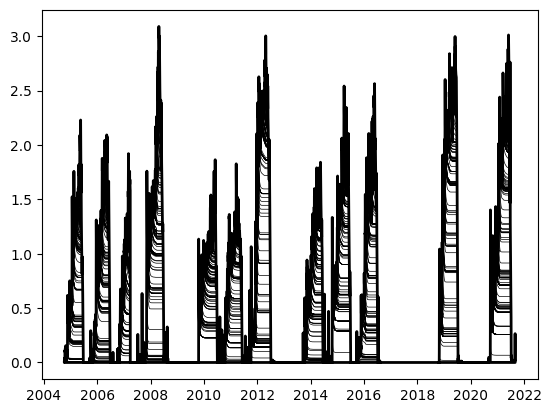

In [128]:
fig, ax = plt.subplots()
jopack.visualization.layer_plot(
    ax,
    hs_with_layers,
    color_variable=None,
)
plt.show()


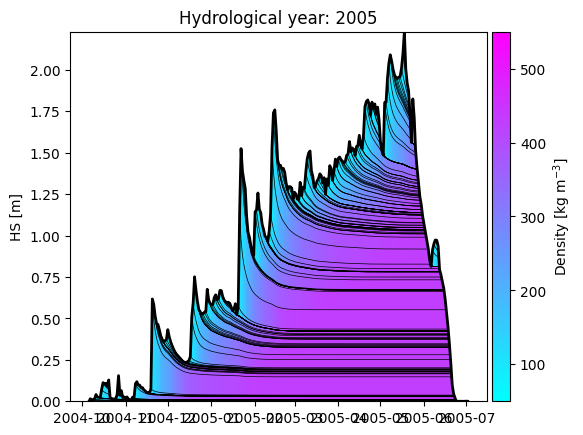

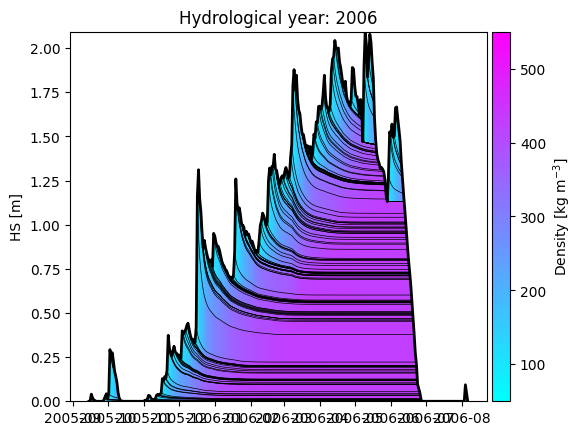

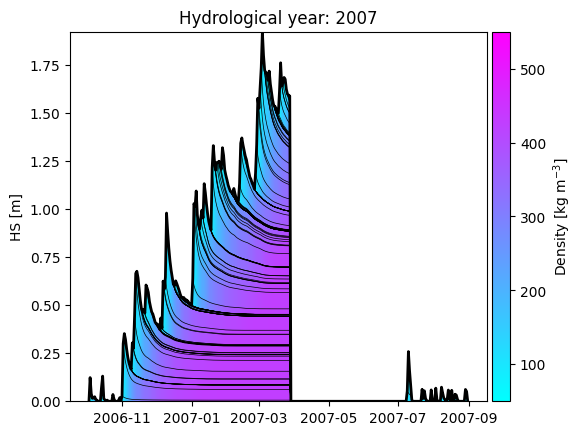

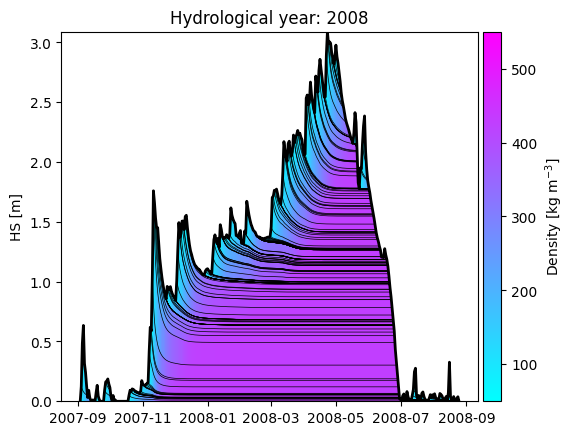

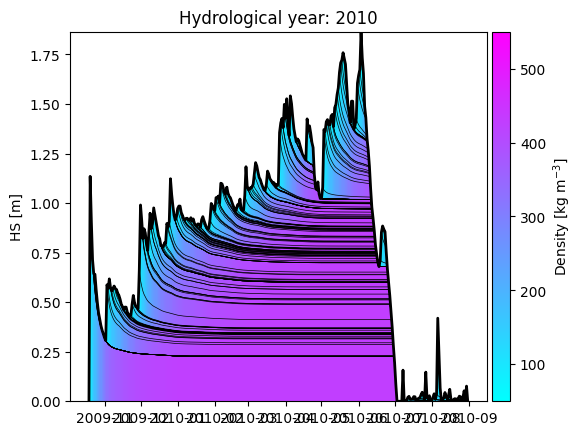

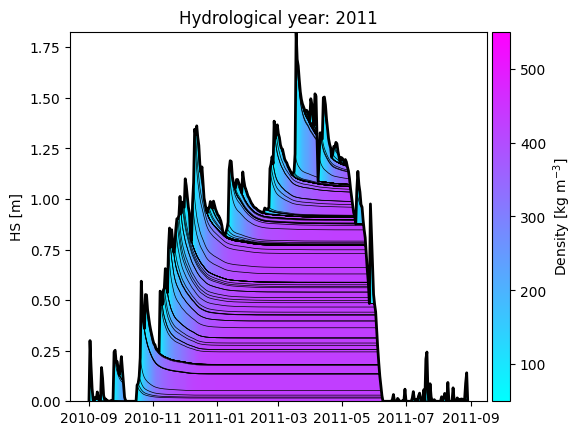

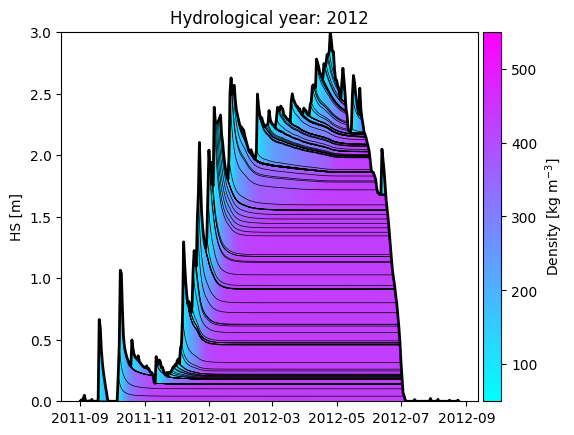

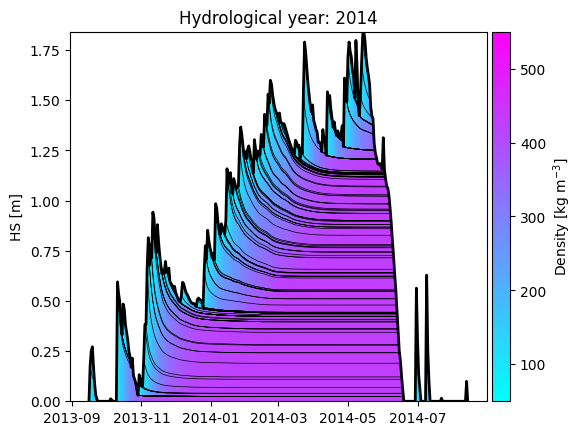

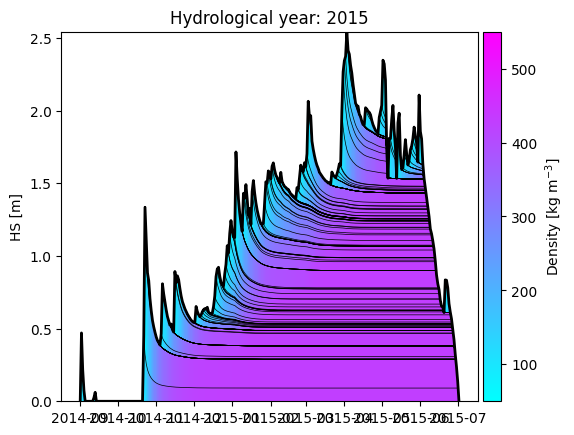

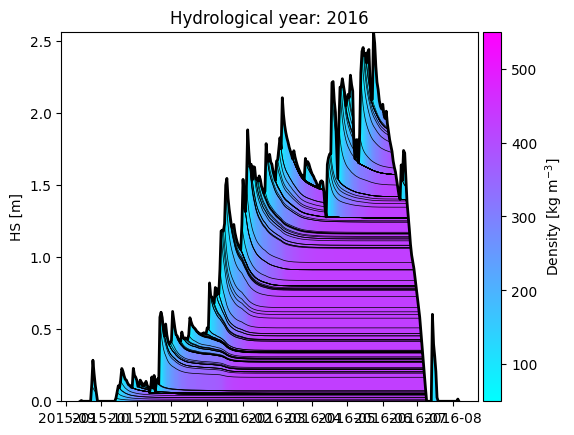

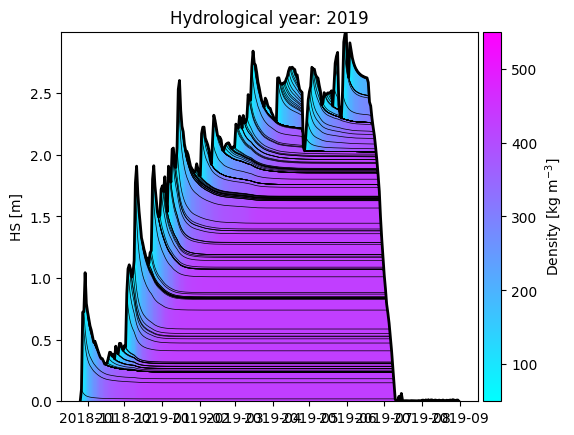

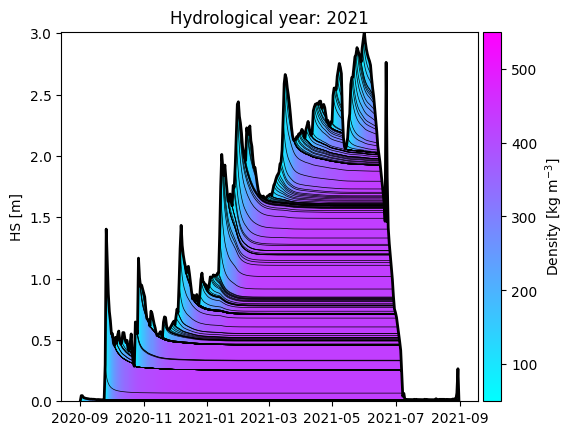

In [129]:
grouped_hydro_years = jopack.visualization.groupby_hydroyear(
    hs_with_layers,
    split=9,
)

for year, yearly_data in grouped_hydro_years:
    fig, ax = plt.subplots()
    jopack.visualization.layer_plot(
        ax,
        yearly_data,
        color_variable='layer_densities',
        cbar_label='Density [kg m$^{-3}$]'
    )
    ax.set_ylabel('HS [m]')
    ax.set_title(f'Hydrological year: {year}')
    plt.show()


In [132]:
df['date']
# df_1991 = df_ts.loc['1991']
# hs_1991 = jopack.convert_1d(df_1991['swe'], swe_input_unit='m', hs_output_unit='m')
# hs_1991


19505   2018-10-26
19506   2018-10-27
19507   2018-10-28
19508   2018-10-29
19509   2018-10-30
           ...    
23087   2016-07-18
23088   2016-07-19
23089   2016-08-04
23090   2016-08-05
23091   2016-08-06
Name: date, Length: 3587, dtype: datetime64[ns]

In [171]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
y_true = swe['actual_hs']         # actual values
y_pred = predicted_hs             # predicted values

MAE = mean_absolute_error(y_true, y_pred)
MSE = mean_squared_error(y_true, y_pred)
R2  = r2_score(y_true, y_pred)
RMSE = MSE**0.5

print('MAE:', MAE)
print('MSE:', MSE)
print('R²:', R2)
print('RMSE:', RMSE)



MAE: 0.14619463077805048
MSE: 0.044529182304009096
R²: 0.9340244723540715
RMSE: 0.21101938845520593


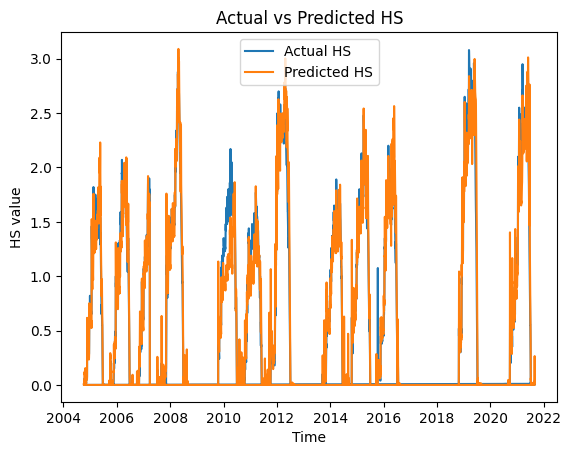

In [137]:

plt.figure()
plt.plot(swe['actual_hs'], label='Actual HS')
plt.plot(predicted_hs, label='Predicted HS')

plt.xlabel('Time')
plt.ylabel('HS value')
plt.title('Actual vs Predicted HS')
plt.legend()
plt.show()


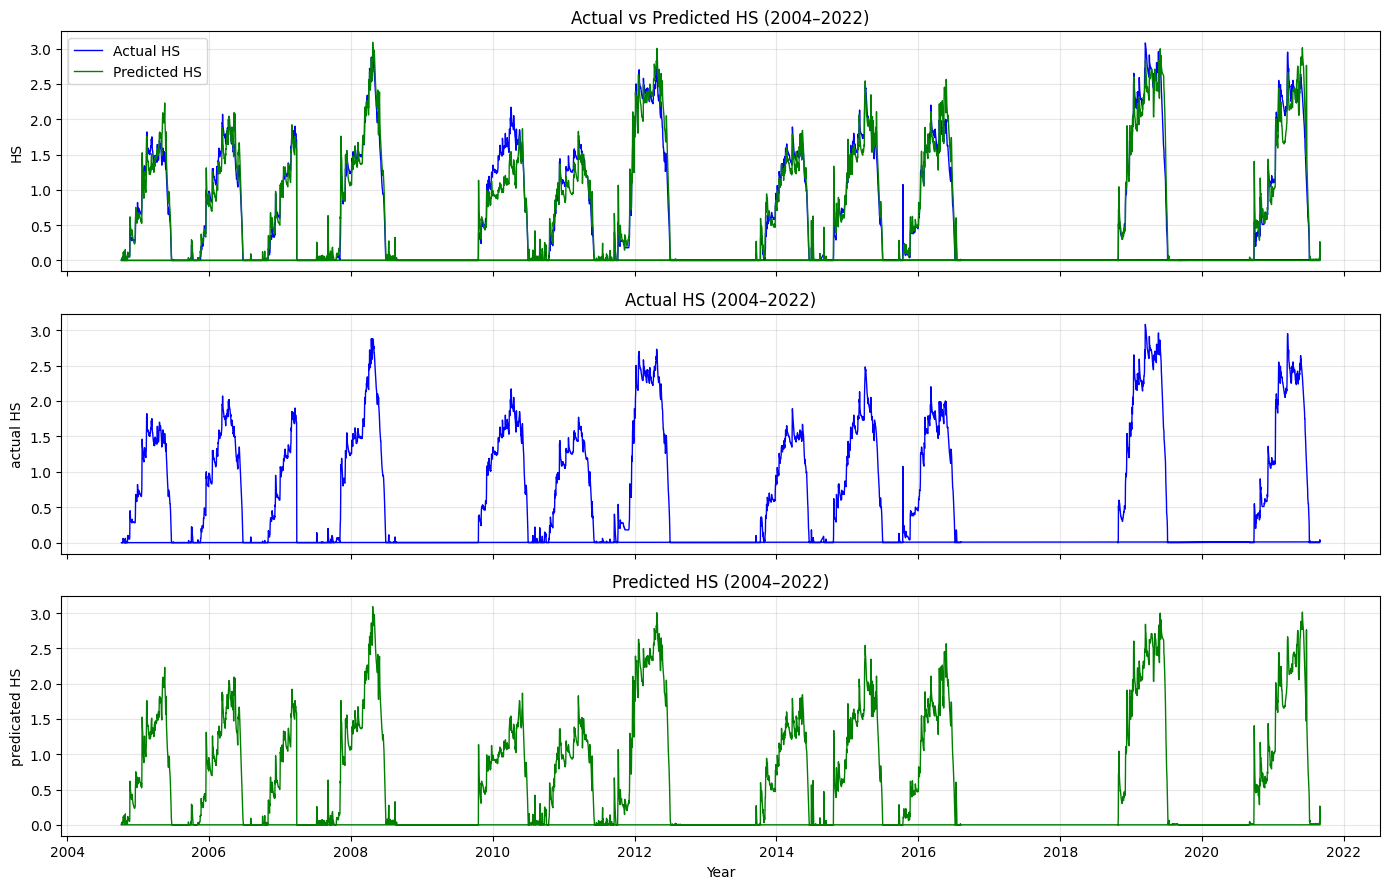

In [192]:
# import matplotlib.pyplot as plt

time = swe.index

fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

# 1️⃣ Actual vs Predicted
axes[0].plot(time, swe['actual_hs'], label='Actual HS', color='blue', linewidth=1)
axes[0].plot(time, predicted_hs, label='Predicted HS', color='green', linewidth=1)
axes[0].set_title('Actual vs Predicted HS (2004–2022)')
axes[0].set_ylabel('HS')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2️⃣ Actual only
axes[1].plot(time, swe['actual_hs'], color='blue', linewidth=1)
axes[1].set_title('Actual HS (2004–2022)')
axes[1].set_ylabel('actual HS')
axes[1].grid(True, alpha=0.3)

# 3️⃣ Predicted only
axes[2].plot(time, predicted_hs, color='green', linewidth=1)
axes[2].set_title('Predicted HS (2004–2022)')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('predicated HS')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [161]:

df_CDP=df[df['site_id']=='CDP_aws']
df_CDP['date']

0       2002-05-01
1       2002-05-02
2       2002-05-03
3       2002-05-04
4       2002-05-05
           ...    
2038    2017-05-03
2039    2017-05-04
2040    2017-05-05
2041    2017-05-06
2042    2017-05-07
Name: date, Length: 2043, dtype: object

In [162]:
# 1. Convert date column to datetime
df_CDP['date'] = pd.to_datetime(df_CDP['date'])
# 2. Set date as index
df_ts_CDP = df_CDP.set_index('date')
# 3. Keep only SWE column (rename to 'swe' if you want)
df_ts_CDP = df_ts_CDP[['SWE_[m]','HS_[m]']].rename(columns={'SWE_[m]': 'swe','HS_[m]':'actual_hs'})

In [163]:
swe_CDP=df_ts_CDP
swe_CDP

,swe,actual_hs
date,,
2002-05-01,0.000,0.00
2002-05-02,0.023,0.00
2002-05-03,0.049,0.27
2002-05-04,0.069,0.36
2002-05-05,0.069,0.42
...,...,...
2017-05-03,0.042,0.06
2017-05-04,0.036,0.03
2017-05-05,0.018,0.01


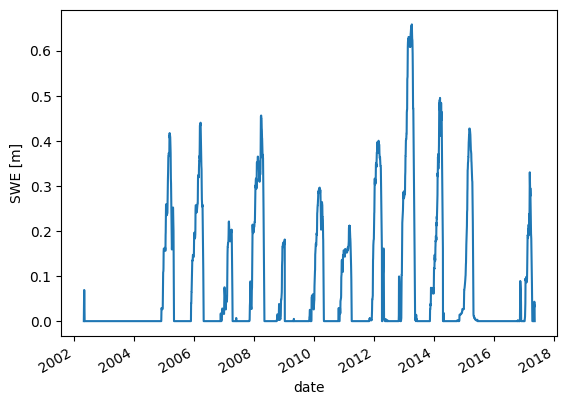

In [164]:

swe_CDP['swe'].plot(ylabel='SWE [m]')
plt.show()


In [ ]:
predicted_hs_CDP = jopack.convert_1d(swe_CDP['swe'], swe_input_unit='m', hs_output_unit='m')

In [166]:
# hs validation/score model
from sklearn.metrics import r2_score
r2_score(swe_CDP['actual_hs'], predicted_hs_CDP)

0.7763185516033219

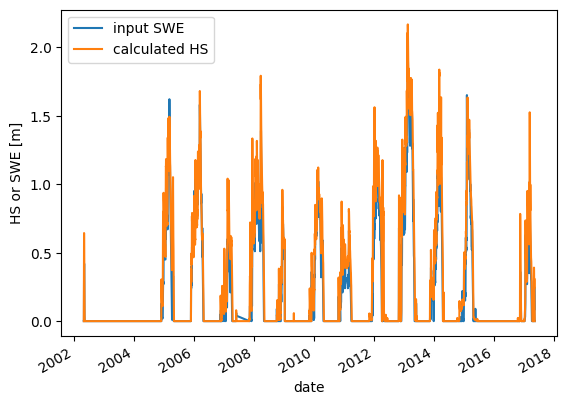

In [167]:
fig, ax = plt.subplots()
swe_CDP['actual_hs'].plot(label='input SWE')
predicted_hs_CDP.plot(label='calculated HS')
ax.legend()
ax.set_ylabel('HS or SWE [m]')
plt.show()


In [169]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_true = swe_CDP['actual_hs']         # actual values
y_pred = predicted_hs_CDP             # predicted values

MAE = mean_absolute_error(y_true, y_pred)
MSE = mean_squared_error(y_true, y_pred)
R2  = r2_score(y_true, y_pred)
RMSE = MSE**0.5

print('MAE:', MAE)
print('MSE:', MSE)
print('R²:', R2)
print('RMSE:', RMSE)


MAE: 0.15235073508724029
MSE: 0.04098300150447917
R²: 0.7763185516033219
RMSE: 0.20244258816879213


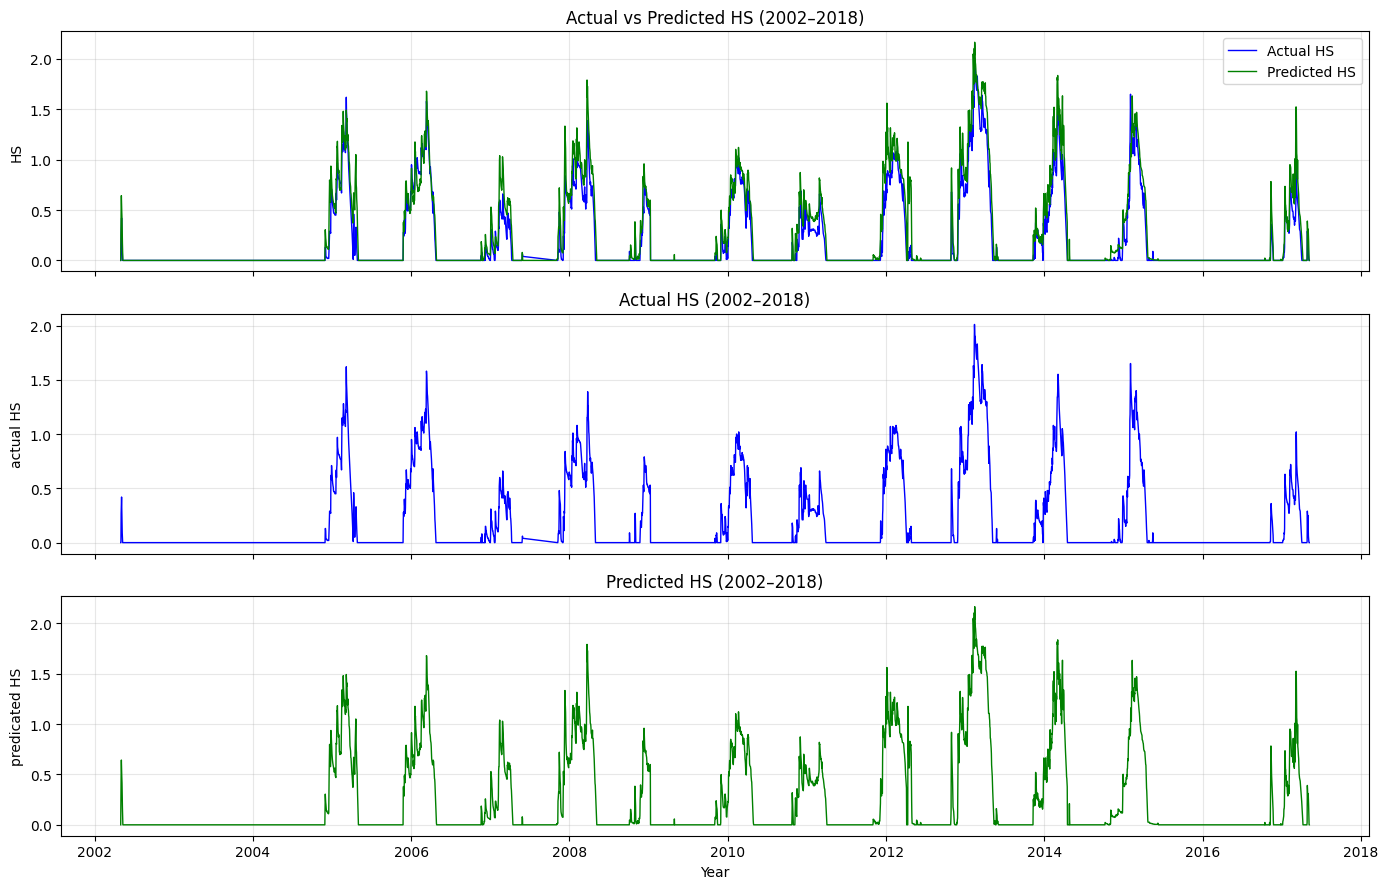

In [188]:

# import matplotlib.pyplot as plt
time = df_CDP['date']

fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

# 1️⃣ Actual vs Predicted
axes[0].plot(time, swe_CDP['actual_hs'], label='Actual HS', color='blue', linewidth=1)
axes[0].plot(time, predicted_hs_CDP, label='Predicted HS', color='green', linewidth=1)
axes[0].set_title('Actual vs Predicted HS (2002–2018)')
axes[0].set_ylabel('HS')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2️⃣ Actual only
axes[1].plot(time, swe_CDP['actual_hs'], color='blue', linewidth=1)
axes[1].set_title('Actual HS (2002–2018)')
axes[1].set_ylabel('actual HS')
axes[1].grid(True, alpha=0.3)

# 3️⃣ Predicted only
axes[2].plot(time, predicted_hs_CDP, color='green', linewidth=1)
axes[2].set_title('Predicted HS (2002–2018)')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('predicated HS')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [186]:
# swe.index

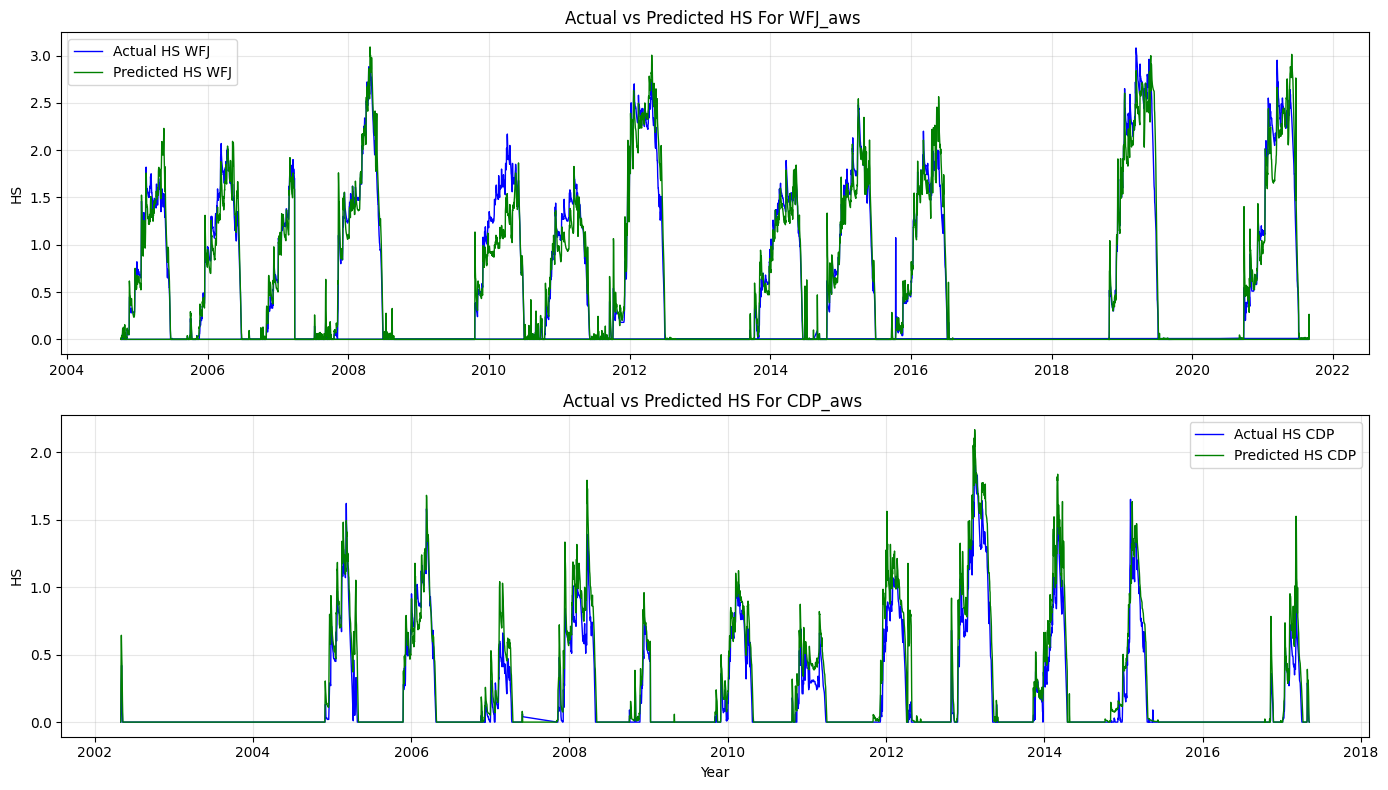

In [187]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=False)

# WFJ AWS
time_WFJ = swe.index
mask_WFJ = ~swe['actual_hs'].isna() & ~predicted_hs.isna()
axes[0].plot(time_WFJ[mask_WFJ], swe['actual_hs'][mask_WFJ], label='Actual HS WFJ', color='blue', linewidth=1)
axes[0].plot(time_WFJ[mask_WFJ], predicted_hs[mask_WFJ], label='Predicted HS WFJ', color='green', linewidth=1)
axes[0].set_title('Actual vs Predicted HS For WFJ_aws ')
axes[0].set_ylabel('HS')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# CDP AWS
time_CDP = swe_CDP.index
mask_CDP = ~swe_CDP['actual_hs'].isna() & ~predicted_hs_CDP.isna()
axes[1].plot(time_CDP[mask_CDP], swe_CDP['actual_hs'][mask_CDP], label='Actual HS CDP', color='blue', linewidth=1)
axes[1].plot(time_CDP[mask_CDP], predicted_hs_CDP[mask_CDP], label='Predicted HS CDP', color='green', linewidth=1)
axes[1].set_title('Actual vs Predicted HS For CDP_aws ')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('HS')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
